In [18]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Kaustade nimed ja klasside määramine
class_names = ["COVID19", "NORMAL", "PNEUMONIA", "TURBERCULOSIS"]
image_data = []
labels = []
# Andmete laadimine
for idx, class_name in enumerate(class_names):
    folder_path = f"Chest X_Ray Dataset/{class_name}"
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(img)
        labels.append(idx)  # Määrake klassi indeks

In [19]:
# Muuda andmed numpy massiivideks
image_data = np.array(image_data)
labels = np.array(labels)
# Andmete jaotamine treening-, valideerimis- ja testikomplektideks
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42
)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [20]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
datagen.fit(X_train)

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Kasuta eelnevalt treenitud ResNet50 mudelit
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Ära treeni eelnevalt treenitud kihti

In [22]:
# Täiendame mudelit
model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint  # LISATUD

checkpoint_dir = "model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}.keras"),
    save_weights_only=False,  # Salvesta kogu mudel
    save_best_only=True,  # Salvesta iga epohhi lõpus
    verbose=1,
)

In [24]:
# Treenime mudelit
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=400,  # mingi 10 minimum äkki sobiks
    callbacks=[checkpoint_callback],  # lisatud........
)

c:\Users\miron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/400
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5765 - loss: 1.1070
Epoch 1: val_loss improved from inf to 1.06796, saving model to model_checkpoints\model_epoch_01.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 444ms/step - accuracy: 0.5766 - loss: 1.1068 - val_accuracy: 0.5844 - val_loss: 1.0680
Epoch 2/400
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6078 - loss: 1.0373
Epoch 2: val_loss improved from 1.06796 to 1.04891, saving model to model_checkpoints\model_epoch_02.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 436ms/step - accuracy: 0.6078 - loss: 1.0373 - val_accuracy: 0.5950 - val_loss: 1.0489
Epoch 3/400
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6134 - loss: 0.9915
Epoch 3: val_loss did not improve from 1.04891
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 427ms/step - accuracy: 0.6134 - loss: 0.9916 - val_accuracy: 0.5844 - val_loss: 1.0812
Epoch 4/400
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6096 - loss: 1.0067
Epoch 4: val_loss improved 

In [25]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step
[[ 65   7  59   2]
 [  1 214 102   0]
 [  0  39 795   1]
 [ 35   5  50  52]]
              precision    recall  f1-score   support

           0       0.64      0.49      0.56       133
           1       0.81      0.68      0.74       317
           2       0.79      0.95      0.86       835
           3       0.95      0.37      0.53       142

    accuracy                           0.79      1427
   macro avg       0.80      0.62      0.67      1427
weighted avg       0.80      0.79      0.77      1427



In [26]:
results = model.evaluate(X_test, y_test, batch_size=8)
print(model.metrics_names)  # Kuvab saadavalolevate mõõdikute nimed
print(results)

179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.7769 - loss: 0.5124
['loss', 'compile_metrics']
[0.49971821904182434, 0.7890679836273193]


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


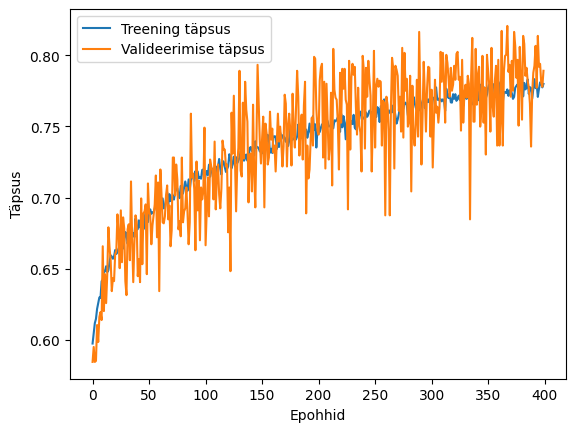

In [27]:
import matplotlib.pyplot as plt

print(history.history.keys())  #
plt.plot(history.history["accuracy"], label="Treening täpsus")
plt.plot(history.history["val_accuracy"], label="Valideerimise täpsus")
plt.xlabel("Epohhid")
plt.ylabel("Täpsus")
plt.legend()
plt.show()

In [28]:
print(f"accuracy: {history.history['val_accuracy']}")
print(f"accuracy: {history.history['accuracy']}")

accuracy: [0.5844429135322571, 0.5949544310569763, 0.5844429135322571, 0.5851436853408813, 0.6103714108467102, 0.5984582901000977, 0.6159775853157043, 0.6194814443588257, 0.6138752698898315, 0.6657323241233826, 0.62018221616745, 0.6461107134819031, 0.6257883906364441, 0.6461107134819031, 0.6790469288825989, 0.6650315523147583, 0.6559215188026428, 0.6341975927352905, 0.643307626247406, 0.6412053108215332, 0.6601261496543884, 0.6622284650802612, 0.6881569623947144, 0.6755430698394775, 0.6503153443336487, 0.6909600496292114, 0.6545199751853943, 0.6860546469688416, 0.6783461570739746, 0.6412053108215332, 0.6313945055007935, 0.6776453852653503, 0.6811492443084717, 0.6559215188026428, 0.7112824320793152, 0.6706377267837524, 0.6405045390129089, 0.6678346395492554, 0.6874561905860901, 0.6832515597343445, 0.6447091698646545, 0.6566222906112671, 0.6405045390129089, 0.6993693113327026, 0.6531184315681458, 0.6888577342033386, 0.6902592778205872, 0.695164680480957, 0.6461107134819031, 0.70988088846

<h1>uute piltide testimine<h1>


<font color="red">Ma tegin kausta "uued" ja panin sinna pildid ja siis üritab
neid arvata</font>


In [29]:
import tensorflow as tf


new_images_path = "uued"  # Kaust, kus on uued pildid

# Kategooriate nimed
categories = ["COVID19", "PNEUMONIA", "TUBERCOLOSIS", "NORMAL"]

# Laadime uued pildid
new_images = []
for img_name in os.listdir(new_images_path):
    img_path = os.path.join(new_images_path, img_name)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    new_images.append(img_array)

# Muudame uued pildid numpy massiiviks
new_images = np.array(new_images)

# Normaliseerime pildid, et need oleksid vahemikus [0, 1]
new_images = new_images / 255.0

# Ennustamine uute piltide kohta
predictions = model.predict(new_images)

# Kuvame tulemused
for i, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)  # Kõrgeima tõenäosusega klass
    print(
        f"Pilt {i+1}: Ennustus: {categories[predicted_class]}, Tõenäosus: {prediction[predicted_class]:.2f}"
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Pilt 1: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.75
Pilt 2: Ennustus: PNEUMONIA, Tõenäosus: 0.73
Pilt 3: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.87
Pilt 4: Ennustus: TUBERCOLOSIS, Tõenäosus: 0.53


In [30]:
from tensorflow.keras.utils import image_dataset_from_directory

# Lae testandmestik
test_dataset = image_dataset_from_directory(
    "Chest X_Ray Dataset",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
)

# Hindamine mudeliga
loss, accuracy = model.evaluate(test_dataset)
print(f"Testandmete täpsus: {accuracy:.2f}")

Found 7132 files belonging to 4 classes.
223/223 ━━━━━━━━━━━━━━━━━━━━ 90s 399ms/step - accuracy: 0.0834 - loss: 271.9757
Testandmete täpsus: 0.08


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


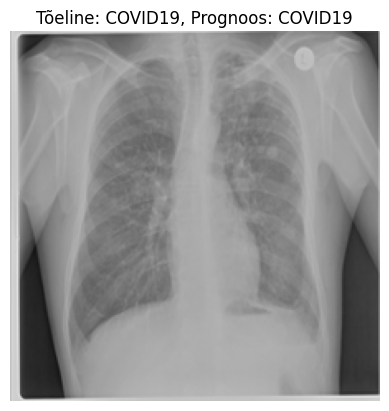

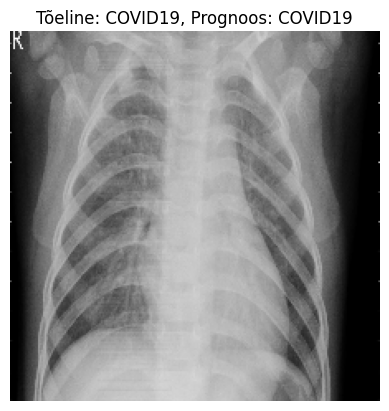

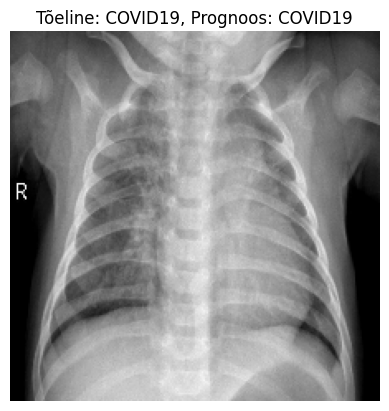

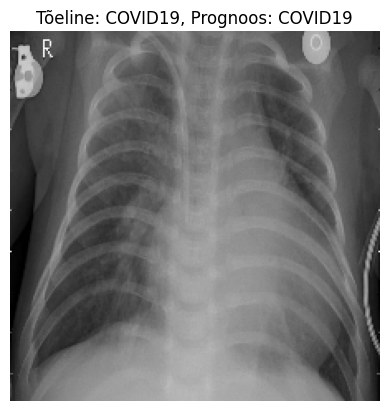

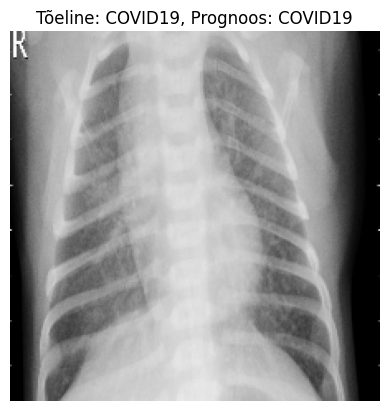

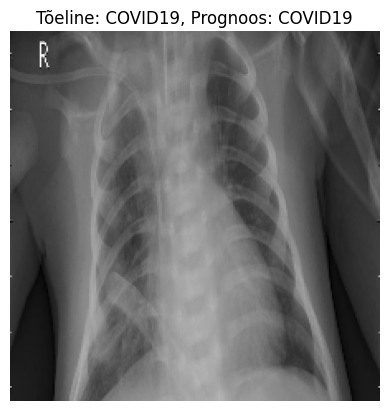

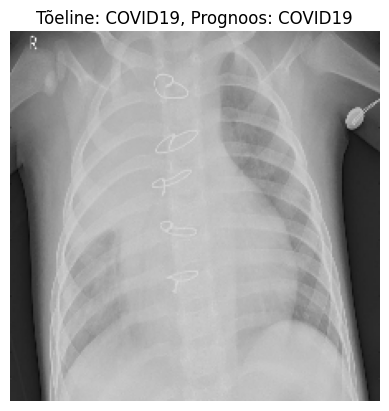

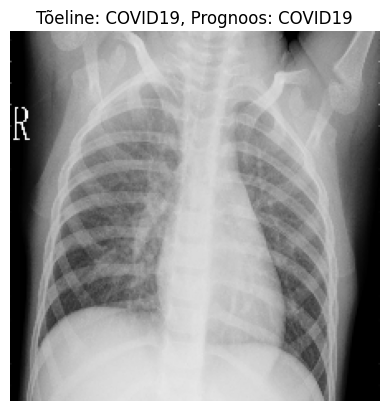

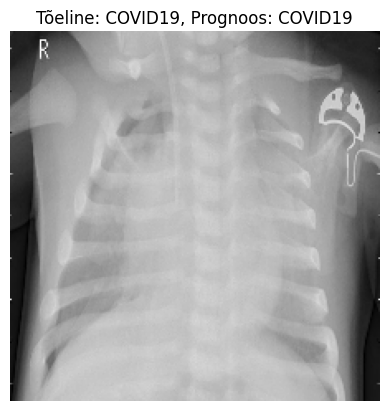

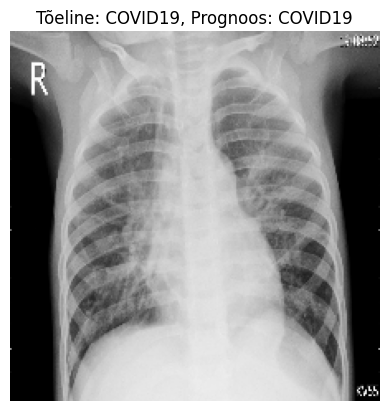

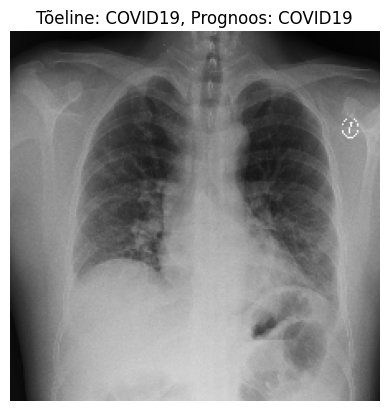

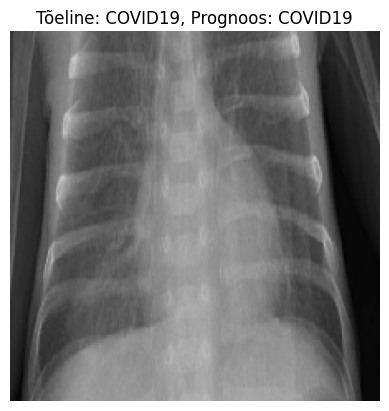

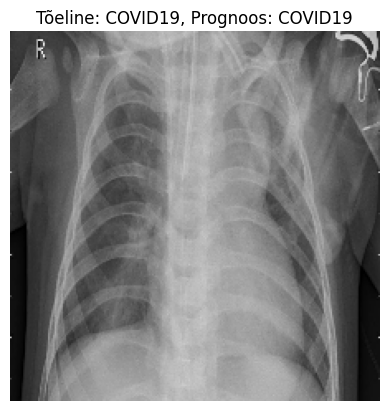

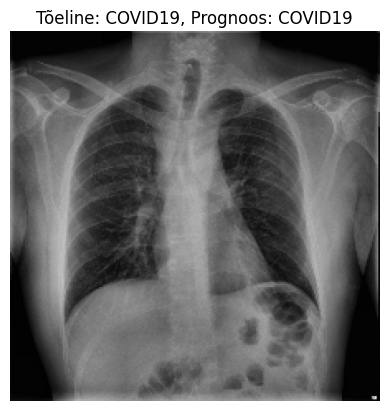

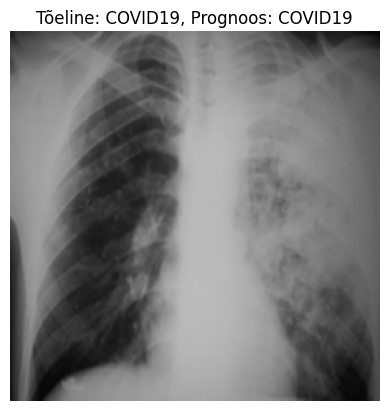

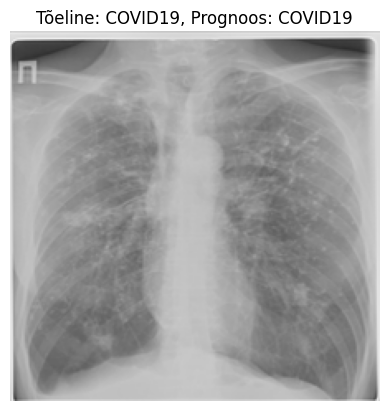

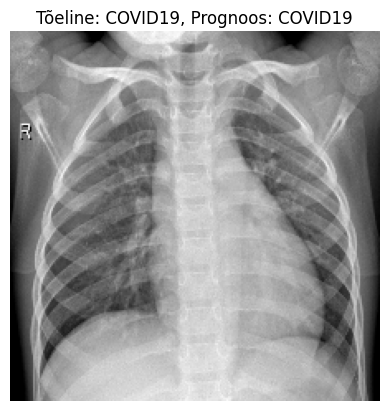

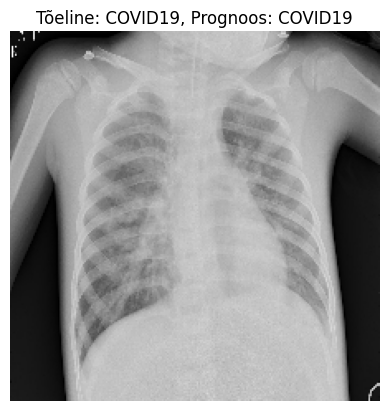

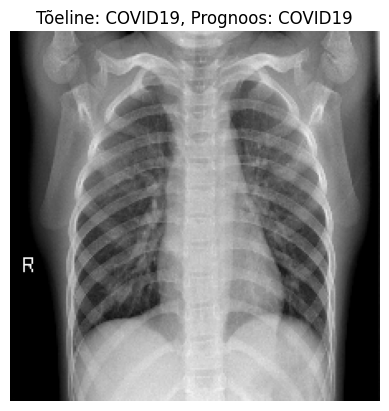

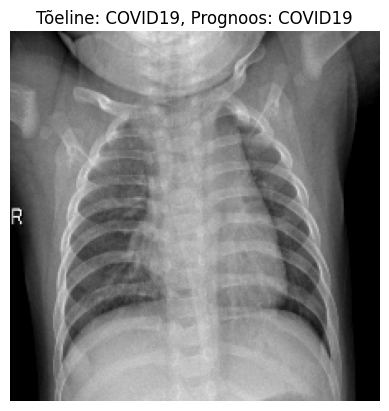

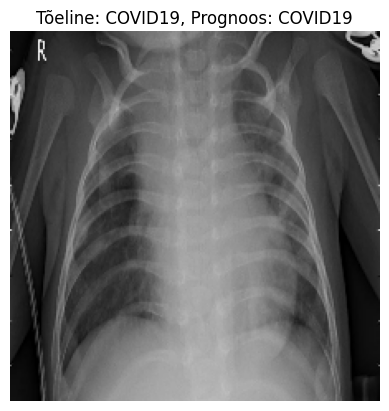

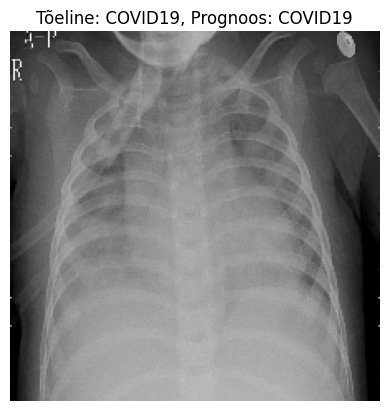

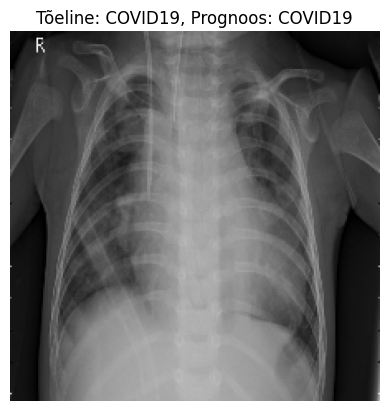

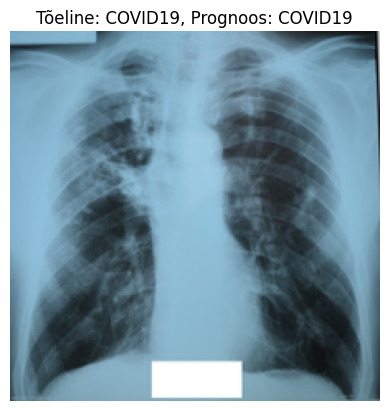

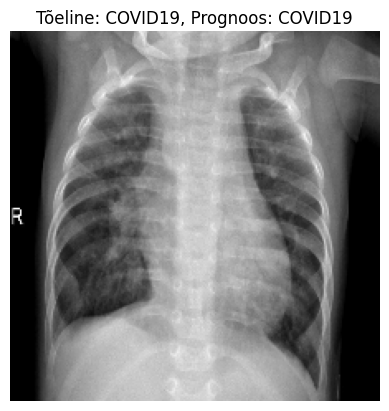

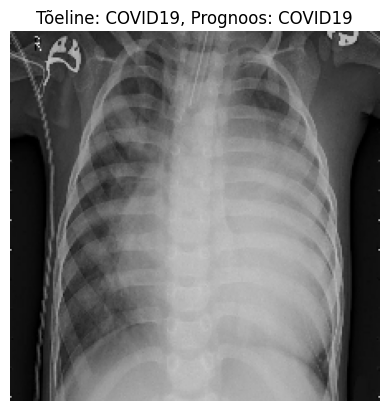

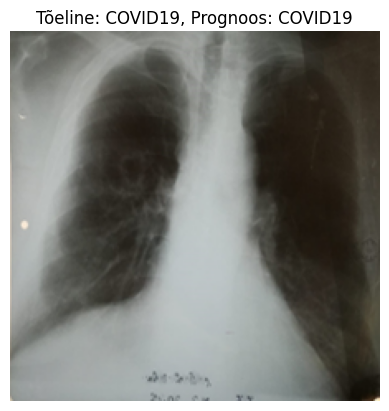

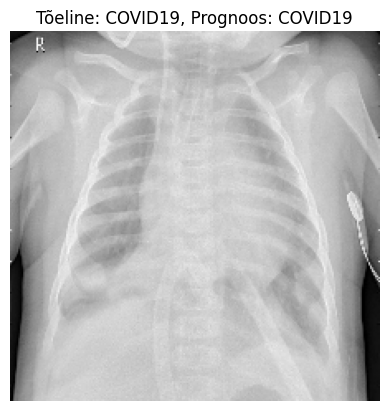

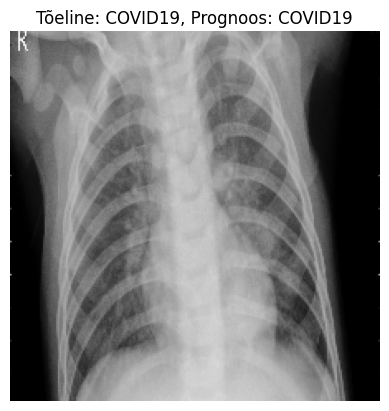

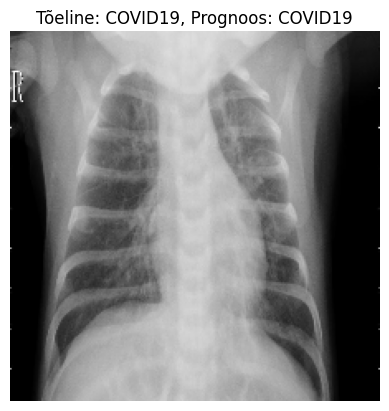

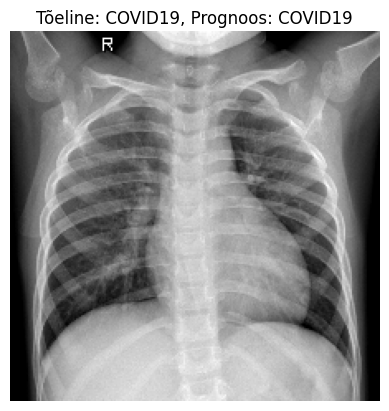

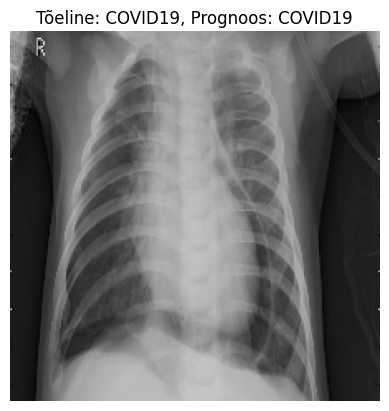

In [31]:
import matplotlib.pyplot as plt

for images, labels in test_dataset.take(1):  # Võta esimene partii testandmeid
    predictions = model.predict(images)
    for i in range(len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = categories[np.argmax(predictions[i])]
        true_class = categories[np.argmax(labels[i].numpy())]
        plt.title(f"Tõeline: {true_class}, Prognoos: {predicted_class}")
        plt.axis("off")
        plt.show()

In [32]:
def load_model_from_epoch(epoch_num):  # lisatud
    model_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch_num:02d}.keras")
    if os.path.exists(model_path):
        print(f"Laen mudelit failist: {model_path}")
        return tf.keras.models.load_model(model_path)
    else:
        raise FileNotFoundError(f"Faili {model_path} ei leitud.")


loaded_model = load_model_from_epoch(2)
# Kuvage mudeli struktuur
loaded_model.summary()
"""
# Prognoosige testandmetega
for images, labels in test_dataset.take(1):
    predictions = loaded_model.predict(images)
    print(predictions)
"""

Laen mudelit failist: model_checkpoints\model_epoch_02.keras


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

'\n# Prognoosige testandmetega\nfor images, labels in test_dataset.take(1):\n    predictions = loaded_model.predict(images)\n    print(predictions)\n'

Laen mudelit failist: model_checkpoints\model_epoch_368.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 18s 391ms/step
[[ 97   6  27   3]
 [  1 225  91   0]
 [  5  45 782   3]
 [ 43   4  28  67]]
              precision    recall  f1-score   support

           0       0.66      0.73      0.70       133
           1       0.80      0.71      0.75       317
           2       0.84      0.94      0.89       835
           3       0.92      0.47      0.62       142

    accuracy                           0.82      1427
   macro avg       0.81      0.71      0.74      1427
weighted avg       0.82      0.82      0.81      1427



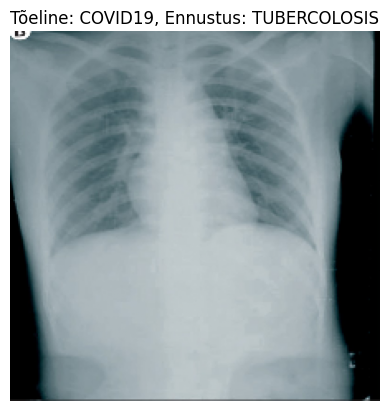

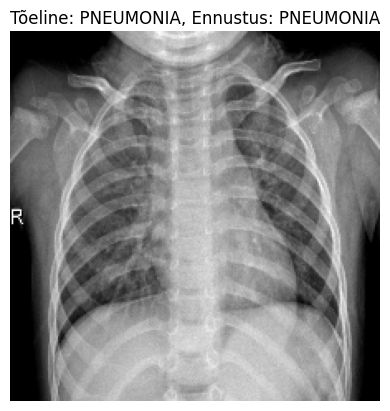

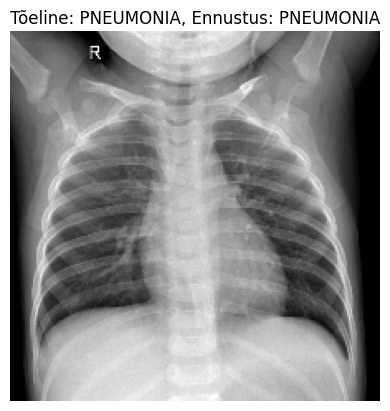

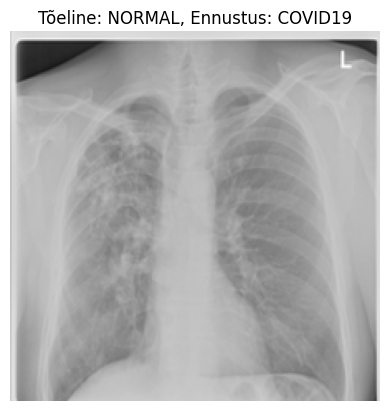

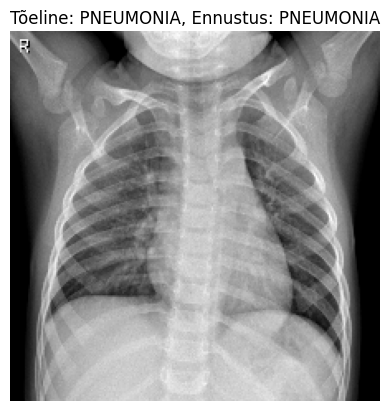

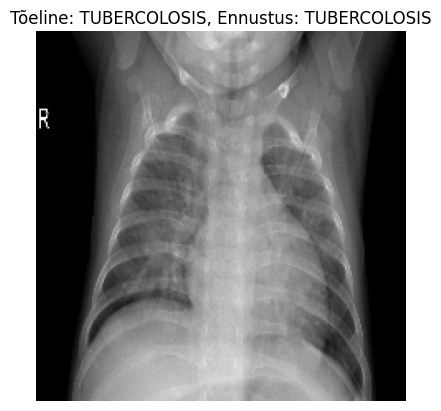

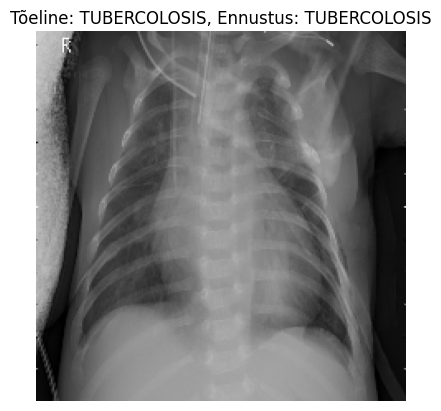

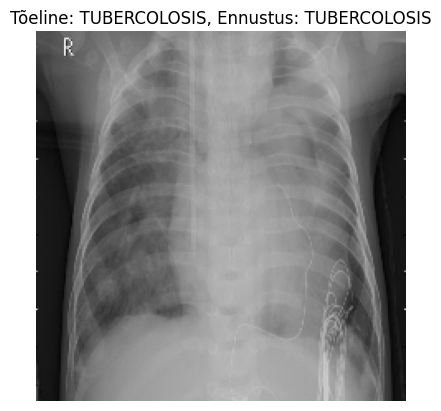

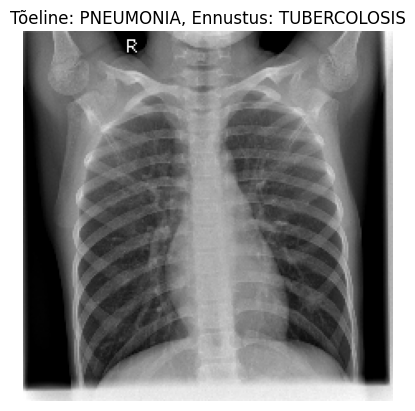

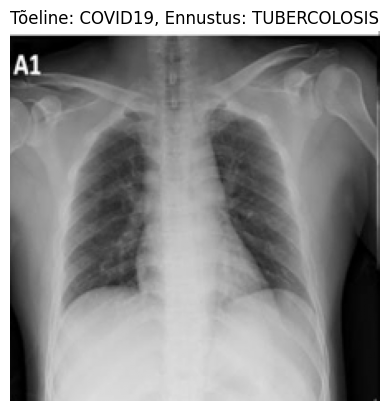

In [34]:
# vali mis mudeliga tahad testida
loaded_model = load_model_from_epoch(368)

# Ennustamine testandmetega
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Kuvame tulemused
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

# Kuvame mõned ennustused koos piltidega
import matplotlib.pyplot as plt

for i in range(10):  # Kuvame esimesed 10 pilti ja nende ennustused
    plt.imshow(X_test[i])
    true_class = categories[y_test[i]]
    predicted_class = categories[y_pred_classes[i]]
    plt.title(f"Tõeline: {true_class}, Ennustus: {predicted_class}")
    plt.axis("off")
    plt.show()